调参策略

最大化  off_ks + 0.8(off_ks-train_ks)

In [1]:
import pandas as pd
from sklearn.metrics import roc_auc_score,roc_curve,auc
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
import numpy as np
import random
import math
import time
import lightgbm as lgb

In [2]:
data = pd.read_csv('Bcard.txt')
data.head()

,obs_mth,bad_ind,uid,td_score,jxl_score,mj_score,rh_score,zzc_score,zcx_score,person_info,finance_info,credit_info,act_info
0,2018-10-31,0.0,A10000005,0.675349,0.144072,0.186899,0.483640,0.928328,0.369644,-0.322581,0.023810,0.00,0.217949
1,2018-07-31,0.0,A1000002,0.825269,0.398688,0.139396,0.843725,0.605194,0.406122,-0.128677,0.023810,0.00,0.423077
2,2018-09-30,0.0,A1000011,0.315406,0.629745,0.535854,0.197392,0.614416,0.320731,0.062660,0.023810,0.10,0.448718
3,2018-07-31,0.0,A10000481,0.002386,0.609360,0.366081,0.342243,0.870006,0.288692,0.078853,0.071429,0.05,0.179487
4,2018-07-31,0.0,A1000069,0.406310,0.405352,0.783015,0.563953,0.715454,0.512554,-0.261014,0.023810,0.00,0.423077


In [3]:
data.shape

(95806, 13)

In [4]:
#看一下月份分布，我们用最后一个月做为跨时间验证集合
data.obs_mth.unique()

array(['2018-10-31', '2018-07-31', '2018-09-30', '2018-06-30',
       '2018-11-30'], dtype=object)

In [5]:
df_train = data[data.obs_mth != '2018-11-30'].reset_index().copy()
val = data[data.obs_mth == '2018-11-30'].reset_index().copy()

In [6]:
#这是我们全部的变量，info结尾的是自己做的无监督系统输出的个人表现，score结尾的是收费的外部征信数据
lst = ['person_info','finance_info','credit_info','act_info','td_score','jxl_score','mj_score','rh_score']

In [7]:
df_train = df_train.sort_values(by = 'obs_mth',ascending = False)
df_train.head()

,index,obs_mth,bad_ind,uid,td_score,jxl_score,mj_score,rh_score,zzc_score,zcx_score,person_info,finance_info,credit_info,act_info
0,0,2018-10-31,0.0,A10000005,0.675349,0.144072,0.186899,0.483640,0.928328,0.369644,-0.322581,0.023810,0.00,0.217949
33407,33407,2018-10-31,0.0,A2810176,0.146055,0.079922,0.250568,0.045240,0.766906,0.413713,0.013863,0.023810,0.00,0.269231
33383,33383,2018-10-31,0.0,A2807687,0.551366,0.300781,0.225007,0.045447,0.735733,0.684182,-0.261014,0.071429,0.03,0.269231
33379,33379,2018-10-31,0.0,A2807232,0.708547,0.769513,0.928457,0.739716,0.947453,0.361551,-0.128677,0.047619,0.00,0.269231
33376,33376,2018-10-31,0.0,A2806932,0.482248,0.116658,0.286273,0.056618,0.047024,0.890433,0.078853,0.047619,0.00,0.269231


In [8]:
df_train = df_train.sort_values(by = 'obs_mth',ascending = False)

rank_lst = []
for i in range(1,len(df_train)+1):
    rank_lst.append(i)
    
df_train['rank'] = rank_lst

df_train['rank'] = df_train['rank']/len(df_train)

pct_lst = []
for x in df_train['rank']:
    if x <= 0.2:
        x = 1
    elif x <= 0.4:
        x = 2
    elif x <= 0.6:
        x = 3
    elif x <= 0.8:
        x = 4
    else:
        x = 5
    pct_lst.append(x)
df_train['rank'] = pct_lst        
#train = train.drop('obs_mth',axis = 1)
df_train.head()

,index,obs_mth,bad_ind,uid,td_score,jxl_score,mj_score,rh_score,zzc_score,zcx_score,person_info,finance_info,credit_info,act_info,rank
0,0,2018-10-31,0.0,A10000005,0.675349,0.144072,0.186899,0.483640,0.928328,0.369644,-0.322581,0.02381,0.00,0.217949,1
56822,56822,2018-10-31,0.0,A5492021,0.645511,0.058839,0.543122,0.235281,0.633456,0.186917,-0.053718,0.02381,0.10,0.166667,1
56991,56991,2018-10-31,0.0,A560974,0.299629,0.344316,0.500635,0.245191,0.056203,0.084314,0.078853,0.02381,0.03,0.538462,1
56970,56970,2018-10-31,0.0,A55912,0.929199,0.347249,0.438309,0.188931,0.611842,0.485462,-0.322581,0.02381,0.05,0.743590,1
57520,57520,2018-10-31,0.0,A601797,0.149059,0.803444,0.167015,0.264857,0.208072,0.704634,-0.261014,0.02381,0.00,0.525641,1


In [9]:
df_train['rank'].groupby(df_train['rank']).count()

rank
1    15966
2    15966
3    15966
4    15966
5    15967
Name: rank, dtype: int64

bin_record = pd.DataFrame()
for col in col_lst:
    cb.pct_bin(data,col,'label')
    cb.plot_woe()
    data[col] = cb.trans_to_woe(data[col])
    rcd = cb.get_bin_stats()
    if bin_record.empty:
        bin_record = rcd
    else:
        bin_record = bin_record.append(rcd)
bin_record.head(8)

In [10]:
len(df_train)

79831

In [11]:
#定义lgb函数
def LGB_test(train_x,train_y,test_x,test_y):
    from multiprocessing import cpu_count
    clf = lgb.LGBMClassifier(
        boosting_type='gbdt', num_leaves=31, reg_alpha=0.0, reg_lambda=1,
        max_depth=2, n_estimators=800,max_features = 140, objective='binary',
        subsample=0.7, colsample_bytree=0.7, subsample_freq=1,
        learning_rate=0.05, min_child_weight=50,random_state=None,n_jobs=cpu_count()-1,
        num_iterations = 800 #迭代次数
    )
    clf.fit(train_x, train_y,eval_set=[(train_x, train_y),(test_x,test_y)],eval_metric='auc',early_stopping_rounds=100)
    print(clf.n_features_)

    return clf,clf.best_score_[ 'valid_1']['auc']
feature_lst = {}
ks_train_lst = []
ks_test_lst = []
for rk in set(df_train['rank']):   
    
    # 测试集8.18以后作为跨时间验证集
    
    #定义模型训练集与测试集
    ttest = df_train[df_train['rank'] ==  rk]
    ttrain = df_train[df_train['rank'] !=  rk]
    
    train = ttrain[lst]
    train_y = ttrain.bad_ind
    
    test = ttest[lst]
    test_y = ttest.bad_ind    
    
    start = time.time()
    model,auc = LGB_test(train,train_y,test,test_y)                    
    end = time.time()
    
    #模型贡献度放在feture中
    feature = pd.DataFrame(
                {'name' : model.booster_.feature_name(),
                'importance' : model.feature_importances_
              }).sort_values(by =  ['importance'],ascending = False)
    
       
    #计算训练集、测试集、验证集上的KS和AUC

    y_pred_train_lgb = model.predict_proba(train)[:, 1]
    y_pred_test_lgb = model.predict_proba(test)[:, 1]


    train_fpr_lgb, train_tpr_lgb, _ = roc_curve(train_y, y_pred_train_lgb)
    test_fpr_lgb, test_tpr_lgb, _ = roc_curve(test_y, y_pred_test_lgb)


    train_ks = abs(train_fpr_lgb - train_tpr_lgb).max()
    test_ks = abs(test_fpr_lgb - test_tpr_lgb).max()


    train_auc = metrics.auc(train_fpr_lgb, train_tpr_lgb)
    test_auc = metrics.auc(test_fpr_lgb, test_tpr_lgb)
    
    ks_train_lst.append(train_ks)
    ks_test_lst.append(test_ks)    

    feature_lst[str(rk)] = feature[feature.importance>=20].name

train_ks = np.mean(ks_train_lst)
test_ks = np.mean(ks_test_lst)

ft_lst = {}
for i in range(1,6):
    ft_lst[str(i)] = feature_lst[str(i)]

fn_lst=list(set(ft_lst['1']) & set(ft_lst['2']) 
    & set(ft_lst['3']) & set(ft_lst['4']) &set(ft_lst['5']))

print('train_ks: ',train_ks)
print('test_ks: ',test_ks)

print('ft_lst: ',fn_lst )


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's binary_logloss: 0.0830104	training's auc: 0.6646	valid_1's binary_logloss: 0.125509	valid_1's auc: 0.596277
Training until validation scores don't improve for 100 rounds.
[2]	training's binary_logloss: 0.0817726	training's auc: 0.789501	valid_1's binary_logloss: 0.12306	valid_1's auc: 0.748667
[3]	training's binary_logloss: 0.0812778	training's auc: 0.794867	valid_1's binary_logloss: 0.122186	valid_1's auc: 0.76525
[4]	training's binary_logloss: 0.0807259	training's auc: 0.795342	valid_1's binary_logloss: 0.12116	valid_1's auc: 0.765093
[5]	training's binary_logloss: 0.0798948	training's auc: 0.796415	valid_1's binary_logloss: 0.119536	valid_1's auc: 0.770217
[6]	training's binary_logloss: 0.0791059	training's auc: 0.801681	valid_1's binary_logloss: 0.118081	valid_1's auc: 0.776486
[7]	training's binary_logloss: 0.0786993	training's auc: 0.801082	valid_1's binary_logloss: 0.117443	valid_1's auc: 0.77658
[8]	training's binary_logloss: 0.0781249	training's auc: 0.800744	va

[109]	training's binary_logloss: 0.070942	training's auc: 0.819223	valid_1's binary_logloss: 0.108388	valid_1's auc: 0.783555
[110]	training's binary_logloss: 0.0709362	training's auc: 0.819272	valid_1's binary_logloss: 0.108383	valid_1's auc: 0.783623
[111]	training's binary_logloss: 0.0709268	training's auc: 0.81931	valid_1's binary_logloss: 0.108384	valid_1's auc: 0.783612
[112]	training's binary_logloss: 0.0709204	training's auc: 0.819414	valid_1's binary_logloss: 0.108391	valid_1's auc: 0.783561
[113]	training's binary_logloss: 0.0709143	training's auc: 0.819461	valid_1's binary_logloss: 0.108397	valid_1's auc: 0.783567
[114]	training's binary_logloss: 0.0709101	training's auc: 0.819463	valid_1's binary_logloss: 0.108406	valid_1's auc: 0.783555
[115]	training's binary_logloss: 0.0709063	training's auc: 0.819514	valid_1's binary_logloss: 0.108408	valid_1's auc: 0.783523
[116]	training's binary_logloss: 0.0708995	training's auc: 0.819555	valid_1's binary_logloss: 0.108383	valid_1's 

[8]	training's binary_logloss: 0.0821517	training's auc: 0.802208	valid_1's binary_logloss: 0.100285	valid_1's auc: 0.778284
[9]	training's binary_logloss: 0.0819648	training's auc: 0.802617	valid_1's binary_logloss: 0.100056	valid_1's auc: 0.779607
[10]	training's binary_logloss: 0.0816417	training's auc: 0.803645	valid_1's binary_logloss: 0.0997239	valid_1's auc: 0.779371
[11]	training's binary_logloss: 0.0810782	training's auc: 0.806643	valid_1's binary_logloss: 0.0990585	valid_1's auc: 0.782057
[12]	training's binary_logloss: 0.0806065	training's auc: 0.808114	valid_1's binary_logloss: 0.0984672	valid_1's auc: 0.78357
[13]	training's binary_logloss: 0.0803856	training's auc: 0.807109	valid_1's binary_logloss: 0.0982471	valid_1's auc: 0.782328
[14]	training's binary_logloss: 0.0801605	training's auc: 0.807015	valid_1's binary_logloss: 0.0980243	valid_1's auc: 0.781718
[15]	training's binary_logloss: 0.0797536	training's auc: 0.807205	valid_1's binary_logloss: 0.0975633	valid_1's auc

[122]	training's binary_logloss: 0.0745286	training's auc: 0.820567	valid_1's binary_logloss: 0.0928512	valid_1's auc: 0.796095
[123]	training's binary_logloss: 0.0745251	training's auc: 0.820599	valid_1's binary_logloss: 0.0928538	valid_1's auc: 0.796064
[124]	training's binary_logloss: 0.0745189	training's auc: 0.820653	valid_1's binary_logloss: 0.0928552	valid_1's auc: 0.796044
[125]	training's binary_logloss: 0.074514	training's auc: 0.820694	valid_1's binary_logloss: 0.0928663	valid_1's auc: 0.795995
[126]	training's binary_logloss: 0.0745078	training's auc: 0.820744	valid_1's binary_logloss: 0.0928666	valid_1's auc: 0.796017
[127]	training's binary_logloss: 0.0745052	training's auc: 0.820756	valid_1's binary_logloss: 0.0928757	valid_1's auc: 0.796044
[128]	training's binary_logloss: 0.0744985	training's auc: 0.820854	valid_1's binary_logloss: 0.0928824	valid_1's auc: 0.795942
[129]	training's binary_logloss: 0.0744897	training's auc: 0.820954	valid_1's binary_logloss: 0.0928822	v

[1]	training's binary_logloss: 0.100734	training's auc: 0.649141	valid_1's binary_logloss: 0.0552929	valid_1's auc: 0.618638
Training until validation scores don't improve for 100 rounds.
[2]	training's binary_logloss: 0.0992669	training's auc: 0.76863	valid_1's binary_logloss: 0.0544703	valid_1's auc: 0.798402
[3]	training's binary_logloss: 0.0986745	training's auc: 0.776849	valid_1's binary_logloss: 0.0540647	valid_1's auc: 0.816847
[4]	training's binary_logloss: 0.0980692	training's auc: 0.778518	valid_1's binary_logloss: 0.0537142	valid_1's auc: 0.815667
[5]	training's binary_logloss: 0.09697	training's auc: 0.784558	valid_1's binary_logloss: 0.0530536	valid_1's auc: 0.819038
[6]	training's binary_logloss: 0.0960765	training's auc: 0.785572	valid_1's binary_logloss: 0.052448	valid_1's auc: 0.819855
[7]	training's binary_logloss: 0.0956231	training's auc: 0.785944	valid_1's binary_logloss: 0.0521444	valid_1's auc: 0.820058
[8]	training's binary_logloss: 0.0948725	training's auc: 0.7

[111]	training's binary_logloss: 0.0869108	training's auc: 0.806576	valid_1's binary_logloss: 0.0442735	valid_1's auc: 0.82758
[112]	training's binary_logloss: 0.0869046	training's auc: 0.806644	valid_1's binary_logloss: 0.0442614	valid_1's auc: 0.827613
[113]	training's binary_logloss: 0.0868961	training's auc: 0.806764	valid_1's binary_logloss: 0.044254	valid_1's auc: 0.827503
[114]	training's binary_logloss: 0.0868879	training's auc: 0.806885	valid_1's binary_logloss: 0.0442547	valid_1's auc: 0.827625
[115]	training's binary_logloss: 0.0868828	training's auc: 0.806927	valid_1's binary_logloss: 0.0442373	valid_1's auc: 0.827717
[116]	training's binary_logloss: 0.0868756	training's auc: 0.806946	valid_1's binary_logloss: 0.0442212	valid_1's auc: 0.827716
[117]	training's binary_logloss: 0.0868691	training's auc: 0.807004	valid_1's binary_logloss: 0.0442106	valid_1's auc: 0.827707
[118]	training's binary_logloss: 0.0868655	training's auc: 0.807035	valid_1's binary_logloss: 0.0442083	va

[23]	training's binary_logloss: 0.0845179	training's auc: 0.802396	valid_1's binary_logloss: 0.0701354	valid_1's auc: 0.824915
[24]	training's binary_logloss: 0.0843418	training's auc: 0.802886	valid_1's binary_logloss: 0.0699965	valid_1's auc: 0.824634
[25]	training's binary_logloss: 0.0842026	training's auc: 0.803105	valid_1's binary_logloss: 0.0698515	valid_1's auc: 0.824285
[26]	training's binary_logloss: 0.084042	training's auc: 0.80363	valid_1's binary_logloss: 0.0697159	valid_1's auc: 0.823998
[27]	training's binary_logloss: 0.0838964	training's auc: 0.803753	valid_1's binary_logloss: 0.0695704	valid_1's auc: 0.82429
[28]	training's binary_logloss: 0.0838112	training's auc: 0.804121	valid_1's binary_logloss: 0.0694746	valid_1's auc: 0.825127
[29]	training's binary_logloss: 0.0836781	training's auc: 0.804467	valid_1's binary_logloss: 0.0693609	valid_1's auc: 0.824421
[30]	training's binary_logloss: 0.0835648	training's auc: 0.804503	valid_1's binary_logloss: 0.0692227	valid_1's a

[127]	training's binary_logloss: 0.0811576	training's auc: 0.812317	valid_1's binary_logloss: 0.0667364	valid_1's auc: 0.829639
[128]	training's binary_logloss: 0.0811519	training's auc: 0.812403	valid_1's binary_logloss: 0.0667338	valid_1's auc: 0.829698
[129]	training's binary_logloss: 0.0811475	training's auc: 0.812462	valid_1's binary_logloss: 0.0667409	valid_1's auc: 0.829598
[130]	training's binary_logloss: 0.0811425	training's auc: 0.812479	valid_1's binary_logloss: 0.0667412	valid_1's auc: 0.82944
[131]	training's binary_logloss: 0.0811396	training's auc: 0.81248	valid_1's binary_logloss: 0.0667311	valid_1's auc: 0.829539
[132]	training's binary_logloss: 0.0811318	training's auc: 0.81255	valid_1's binary_logloss: 0.0667239	valid_1's auc: 0.829634
[133]	training's binary_logloss: 0.0811277	training's auc: 0.812562	valid_1's binary_logloss: 0.0667162	valid_1's auc: 0.829708
[134]	training's binary_logloss: 0.0811252	training's auc: 0.812566	valid_1's binary_logloss: 0.0667068	val

[221]	training's binary_logloss: 0.0806494	training's auc: 0.815448	valid_1's binary_logloss: 0.066534	valid_1's auc: 0.830045
[222]	training's binary_logloss: 0.080646	training's auc: 0.815492	valid_1's binary_logloss: 0.0665349	valid_1's auc: 0.829997
[223]	training's binary_logloss: 0.0806419	training's auc: 0.815552	valid_1's binary_logloss: 0.0665299	valid_1's auc: 0.830114
[224]	training's binary_logloss: 0.0806368	training's auc: 0.815579	valid_1's binary_logloss: 0.0665392	valid_1's auc: 0.829986
[225]	training's binary_logloss: 0.0806343	training's auc: 0.815603	valid_1's binary_logloss: 0.0665324	valid_1's auc: 0.829962
[226]	training's binary_logloss: 0.080632	training's auc: 0.815627	valid_1's binary_logloss: 0.0665349	valid_1's auc: 0.829949
[227]	training's binary_logloss: 0.0806212	training's auc: 0.815651	valid_1's binary_logloss: 0.0665338	valid_1's auc: 0.829954
[228]	training's binary_logloss: 0.0806139	training's auc: 0.815712	valid_1's binary_logloss: 0.0665359	val

[319]	training's binary_logloss: 0.0802767	training's auc: 0.818458	valid_1's binary_logloss: 0.0665636	valid_1's auc: 0.829199
[320]	training's binary_logloss: 0.0802727	training's auc: 0.8185	valid_1's binary_logloss: 0.0665741	valid_1's auc: 0.829036
[321]	training's binary_logloss: 0.080268	training's auc: 0.81856	valid_1's binary_logloss: 0.0665784	valid_1's auc: 0.828975
[322]	training's binary_logloss: 0.0802633	training's auc: 0.818593	valid_1's binary_logloss: 0.0665685	valid_1's auc: 0.829056
[323]	training's binary_logloss: 0.0802615	training's auc: 0.818598	valid_1's binary_logloss: 0.0665676	valid_1's auc: 0.829011
[324]	training's binary_logloss: 0.0802587	training's auc: 0.818609	valid_1's binary_logloss: 0.0665657	valid_1's auc: 0.828953
[325]	training's binary_logloss: 0.0802571	training's auc: 0.818606	valid_1's binary_logloss: 0.0665666	valid_1's auc: 0.828883
[326]	training's binary_logloss: 0.0802513	training's auc: 0.81865	valid_1's binary_logloss: 0.0665731	valid

[59]	training's binary_logloss: 0.0775009	training's auc: 0.823658	valid_1's binary_logloss: 0.0844338	valid_1's auc: 0.773853
[60]	training's binary_logloss: 0.0774762	training's auc: 0.823806	valid_1's binary_logloss: 0.0844152	valid_1's auc: 0.773972
[61]	training's binary_logloss: 0.077445	training's auc: 0.823848	valid_1's binary_logloss: 0.0844195	valid_1's auc: 0.773825
[62]	training's binary_logloss: 0.0774002	training's auc: 0.823962	valid_1's binary_logloss: 0.0844144	valid_1's auc: 0.773817
[63]	training's binary_logloss: 0.0773657	training's auc: 0.823981	valid_1's binary_logloss: 0.0844152	valid_1's auc: 0.773801
[64]	training's binary_logloss: 0.0773475	training's auc: 0.824033	valid_1's binary_logloss: 0.084422	valid_1's auc: 0.773824
[65]	training's binary_logloss: 0.0773168	training's auc: 0.823999	valid_1's binary_logloss: 0.0844118	valid_1's auc: 0.773791
[66]	training's binary_logloss: 0.0772955	training's auc: 0.824034	valid_1's binary_logloss: 0.0844012	valid_1's 

[159]	training's binary_logloss: 0.0764419	training's auc: 0.829033	valid_1's binary_logloss: 0.0842669	valid_1's auc: 0.775329
[160]	training's binary_logloss: 0.0764375	training's auc: 0.829028	valid_1's binary_logloss: 0.0842695	valid_1's auc: 0.775344
[161]	training's binary_logloss: 0.0764314	training's auc: 0.829082	valid_1's binary_logloss: 0.0842611	valid_1's auc: 0.775374
[162]	training's binary_logloss: 0.0764223	training's auc: 0.829121	valid_1's binary_logloss: 0.0842559	valid_1's auc: 0.775348
[163]	training's binary_logloss: 0.0764213	training's auc: 0.829145	valid_1's binary_logloss: 0.0842636	valid_1's auc: 0.775384
[164]	training's binary_logloss: 0.0764185	training's auc: 0.829139	valid_1's binary_logloss: 0.0842527	valid_1's auc: 0.775465
[165]	training's binary_logloss: 0.0764134	training's auc: 0.829207	valid_1's binary_logloss: 0.0842665	valid_1's auc: 0.775381
[166]	training's binary_logloss: 0.0764112	training's auc: 0.829236	valid_1's binary_logloss: 0.0842694	

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's binary_logloss: 0.090317	training's auc: 0.712883	valid_1's binary_logloss: 0.0986629	valid_1's auc: 0.678619
Training until validation scores don't improve for 100 rounds.
[2]	training's binary_logloss: 0.0896369	training's auc: 0.779216	valid_1's binary_logloss: 0.0978883	valid_1's auc: 0.755811
[3]	training's binary_logloss: 0.0885026	training's auc: 0.779149	valid_1's binary_logloss: 0.0966811	valid_1's auc: 0.749375
[4]	training's binary_logloss: 0.087998	training's auc: 0.780539	valid_1's binary_logloss: 0.0961527	valid_1's auc: 0.759009
[5]	training's binary_logloss: 0.0871159	training's auc: 0.794722	valid_1's binary_logloss: 0.0952713	valid_1's auc: 0.767316
[6]	training's binary_logloss: 0.0866943	training's auc: 0.793418	valid_1's binary_logloss: 0.0948462	valid_1's auc: 0.769221
[7]	training's binary_logloss: 0.0860007	training's auc: 0.793892	valid_1's binary_logloss: 0.0941714	valid_1's auc: 0.765504
[8]	training's binary_logloss: 0.0856748	training's auc: 

[108]	training's binary_logloss: 0.078633	training's auc: 0.812342	valid_1's binary_logloss: 0.0900995	valid_1's auc: 0.780514
[109]	training's binary_logloss: 0.0786282	training's auc: 0.812392	valid_1's binary_logloss: 0.090106	valid_1's auc: 0.780491
[110]	training's binary_logloss: 0.0786244	training's auc: 0.812437	valid_1's binary_logloss: 0.0901127	valid_1's auc: 0.780464
[111]	training's binary_logloss: 0.0786195	training's auc: 0.812496	valid_1's binary_logloss: 0.0901176	valid_1's auc: 0.780571
[112]	training's binary_logloss: 0.078614	training's auc: 0.812584	valid_1's binary_logloss: 0.0901225	valid_1's auc: 0.780555
[113]	training's binary_logloss: 0.0786083	training's auc: 0.81261	valid_1's binary_logloss: 0.0901318	valid_1's auc: 0.780622
[114]	training's binary_logloss: 0.0786044	training's auc: 0.812636	valid_1's binary_logloss: 0.0901117	valid_1's auc: 0.780666
[115]	training's binary_logloss: 0.0785997	training's auc: 0.812675	valid_1's binary_logloss: 0.0901159	vali

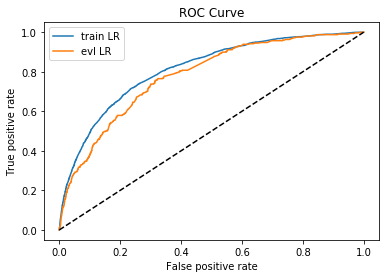

In [13]:
lst = ['person_info','finance_info','credit_info','act_info']

train = data[data.obs_mth != '2018-11-30'].reset_index().copy()
evl = data[data.obs_mth == '2018-11-30'].reset_index().copy()

x = train[lst]
y = train['bad_ind']

evl_x =  evl[lst]
evl_y = evl['bad_ind']

model,auc = LGB_test(x,y,evl_x,evl_y)

y_pred = model.predict_proba(x)[:,1]
fpr_lgb_train,tpr_lgb_train,_ = roc_curve(y,y_pred)
train_ks = abs(fpr_lgb_train - tpr_lgb_train).max()
print('train_ks : ',train_ks)

y_pred = model.predict_proba(evl_x)[:,1]
fpr_lgb,tpr_lgb,_ = roc_curve(evl_y,y_pred)
evl_ks = abs(fpr_lgb - tpr_lgb).max()
print('evl_ks : ',evl_ks)

from matplotlib import pyplot as plt
plt.plot(fpr_lgb_train,tpr_lgb_train,label = 'train LR')
plt.plot(fpr_lgb,tpr_lgb,label = 'evl LR')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve')
plt.legend(loc = 'best')
plt.show()

LightGBM其实效果确实是比较LR要好的，但是我们LR也可以逼近这个效果，下节课我们会具体来做。

In [14]:
#['person_info','finance_info','credit_info','act_info']
#算分数onekey 
def score(xbeta):
    score = 1000-500*(math.log2(1-xbeta)/xbeta)  #好人的概率/坏人的概率
    return score
evl['xbeta'] = model.predict_proba(evl_x)[:,1]   
evl['score'] = evl.apply(lambda x : score(x.xbeta) ,axis=1)

In [15]:
fpr_lr,tpr_lr,_ = roc_curve(evl_y,evl['score'])
evl_ks = abs(fpr_lr - tpr_lr).max()
print('val_ks : ',evl_ks)

val_ks :  0.4416674980164514


In [17]:
#生成报告
row_num, col_num = 0, 0
bins = 20
Y_predict = evl['score']
Y = evl_y
nrows = Y.shape[0]
lis = [(Y_predict[i], Y[i]) for i in range(nrows)]
ks_lis = sorted(lis, key=lambda x: x[0], reverse=True)
bin_num = int(nrows/bins+1)
bad = sum([1 for (p, y) in ks_lis if y > 0.5])
good = sum([1 for (p, y) in ks_lis if y <= 0.5])
bad_cnt, good_cnt = 0, 0
KS = []
BAD = []
GOOD = []
BAD_CNT = []
GOOD_CNT = []
BAD_PCTG = []
BADRATE = []
dct_report = {}
for j in range(bins):
    ds = ks_lis[j*bin_num: min((j+1)*bin_num, nrows)]
    bad1 = sum([1 for (p, y) in ds if y > 0.5])
    good1 = sum([1 for (p, y) in ds if y <= 0.5])
    bad_cnt += bad1
    good_cnt += good1
    bad_pctg = round(bad_cnt/sum(evl_y),3)
    badrate = round(bad1/(bad1+good1),3)
    ks = round(math.fabs((bad_cnt / bad) - (good_cnt / good)),3)
    KS.append(ks)
    BAD.append(bad1)
    GOOD.append(good1)
    BAD_CNT.append(bad_cnt)
    GOOD_CNT.append(good_cnt)
    BAD_PCTG.append(bad_pctg)
    BADRATE.append(badrate)
    dct_report['KS'] = KS
    dct_report['BAD'] = BAD
    dct_report['GOOD'] = GOOD
    dct_report['BAD_CNT'] = BAD_CNT
    dct_report['GOOD_CNT'] = GOOD_CNT
    dct_report['BAD_PCTG'] = BAD_PCTG
    dct_report['BADRATE'] = BADRATE
val_repot = pd.DataFrame(dct_report)
val_repot

,KS,BAD,GOOD,BAD_CNT,GOOD_CNT,BAD_PCTG,BADRATE
0,0.235,92,707,92,707,0.280,0.115
1,0.268,27,772,119,1479,0.363,0.034
2,0.348,42,757,161,2236,0.491,0.053
3,0.387,29,770,190,3006,0.579,0.036
4,0.405,22,777,212,3783,0.646,0.028
5,0.422,22,777,234,4560,0.713,0.028
6,0.427,18,781,252,5341,0.768,0.023
7,0.407,10,789,262,6130,0.799,0.013
8,0.381,8,791,270,6921,0.823,0.010
9,0.373,14,785,284,7706,0.866,0.018


In [150]:
from pyecharts.charts import *
from pyecharts import options as opts
from pylab import *
mpl.rcParams['font.sans-serif'] = ['SimHei']
np.set_printoptions(suppress=True)
pd.set_option('display.unicode.ambiguous_as_wide', True)
pd.set_option('display.unicode.east_asian_width', True)
line = (

    Line()
    .add_xaxis(list(val_repot.index))
    .add_yaxis(
        "分组坏人占比",
        list(val_repot.BADRATE),
        yaxis_index=0,
        color="red",
    )
    .set_global_opts(
        title_opts=opts.TitleOpts(title="行为评分卡模型表现"),
    )
    .extend_axis(
        yaxis=opts.AxisOpts(
            name="累计坏人占比",
            type_="value",
            min_=0,
            max_=0.5,
            position="right",
            axisline_opts=opts.AxisLineOpts(
                linestyle_opts=opts.LineStyleOpts(color="red")
            ),
            axislabel_opts=opts.LabelOpts(formatter="{value}"),
        )

    )
    .add_xaxis(list(val_repot.index))
    .add_yaxis(
        "KS",
        list(val_repot['KS']),
        yaxis_index=1,
        color="blue",
        label_opts=opts.LabelOpts(is_show=False),
    )
)
line.render_notebook()